## 1. Creating Embeddings

In [83]:
import csv
import json
import numpy as np
import seaborn as sns
from scipy import spatial
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

# Read classmates and their responses from a CSV file, replace classmates.csv with own link or file name
attendees_map = {}
with open('classmates.csv', newline='') as csvfile:
    classmates = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(classmates)  # Skip the header row
    for row in classmates:
        name, paragraph = row
        attendees_map[paragraph] = name
        
# Generate sentence embeddings
model = SentenceTransformer('sentence-transformers/multi-qa-distilbert-cos-v1')
paragraphs = list(attendees_map.keys())
embeddings = model.encode(paragraphs)
    
# Create a dictionary to store embeddings for each person
person_embeddings = {attendees_map[paragraph]: embedding for paragraph, embedding in zip(paragraphs, embeddings)}

# Save dictionary to file
person_embeddings = {key: value.tolist() for key, value in person_embeddings.items()} # Convert numpy arrays to lists

with open("embeddings.json", "w") as f:
    json.dump(person_embeddings, f)

## 2. Creating Visualization

In [84]:
# Reducing dimensionality of embedding data, scaling to coordinate domain/range
import umap

reducer = umap.UMAP(random_state=42) # set the seed to 42
scaler = StandardScaler()
scaled_data = scaler.fit_transform(list(person_embeddings.values()))
reduced_data = reducer.fit_transform(scaled_data)

In [85]:
import matplotlib.pyplot as plt

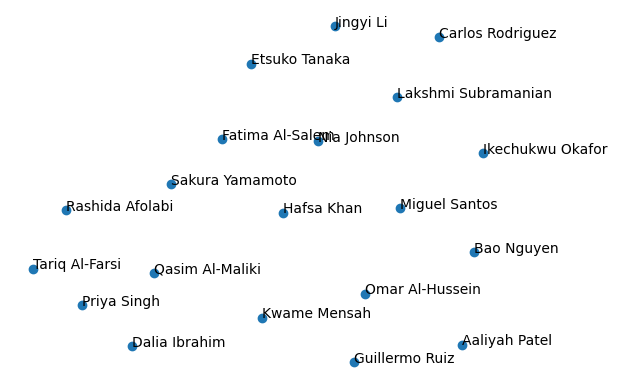

In [86]:
# Creating lists of coordinates with accompanying labels
x = [row[0] for row in reduced_data]
y = [row[1] for row in reduced_data]
label = list(person_embeddings.keys())

# Plotting and annotating data points
plt.scatter(x,y)
for i, name in enumerate(label):
    plt.annotate(name, (x[i], y[i]), fontsize="10")

# Clean-up and Export
plt.axis('off')
plt.savefig('visualization.png', dpi=800)


## 3. [BONUS] Providing top matches

In [87]:
from collections import defaultdict

In [88]:
top_matches = {}
all_personal_pairs = defaultdict(list)
for person in attendees_map.values():
    for person1 in attendees_map.values():
        all_personal_pairs[person].append([spatial.distance.cosine(person_embeddings[person1], person_embeddings[person]), person1])

for person in attendees_map.values():
    top_matches[person] = sorted(all_personal_pairs[person], key=lambda x: x[0])

print(top_matches)


{'Aaliyah Patel': [[0, 'Aaliyah Patel'], [0.7818363234482365, 'Guillermo Ruiz'], [0.8466246449650918, 'Bao Nguyen'], [0.8565854873876516, 'Kwame Mensah'], [0.8685000170095661, 'Carlos Rodriguez'], [0.8942188172534093, 'Dalia Ibrahim'], [0.9238076460725246, 'Ikechukwu Okafor'], [0.9312226980297533, 'Tariq Al-Farsi'], [0.9472714072819772, 'Etsuko Tanaka'], [0.9526341131262522, 'Jingyi Li'], [0.9549647577796101, 'Hafsa Khan'], [0.962980762779189, 'Nia Johnson'], [0.9777983424250806, 'Fatima Al-Salem'], [0.9792625108824003, 'Omar Al-Hussein'], [0.9804760842983902, 'Rashida Afolabi'], [0.986867115572736, 'Priya Singh'], [0.9976665835494343, 'Miguel Santos'], [1.0210029756931585, 'Lakshmi Subramanian'], [1.0213061016802611, 'Qasim Al-Maliki'], [1.0477470525068577, 'Sakura Yamamoto']], 'Bao Nguyen': [[0, 'Bao Nguyen'], [0.6364719603032134, 'Guillermo Ruiz'], [0.6809082727362292, 'Omar Al-Hussein'], [0.7398422720593574, 'Kwame Mensah'], [0.8308928983134702, 'Carlos Rodriguez'], [0.840405628981

## 4. Model Comparison

In [103]:
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr, kendalltau

# Load dictionary from file
with open("../scratch/embeddings-old.json", "r") as f:
    # Use json.load to read the dictionary from the file
    person_embeddings_old = json.load(f)

myKey = "Priya Singh" # using Priya Singh from the GPT generated data for this exercise

# Compute cosine similarity for new embeddings
similarity_new = []
myVal = person_embeddings[myKey]

for key, value in person_embeddings.items():
    thisSimilarity = 1 - cosine(value, myVal)
    similarity_new.append((key, thisSimilarity))

similarity_new.sort(key=lambda x: x[1], reverse=True)

print(similarity_new)

# Compute cosine similarity for new embeddings
similarity_old = []
myVal = person_embeddings_old[myKey]

for key, value in person_embeddings_old.items():
    thisSimilarity = 1 - cosine(value, myVal)
    similarity_old.append((key, thisSimilarity))

similarity_old.sort(key=lambda x: x[1], reverse=True)

print(similarity_old)

# Grab names
new_names = [x[0] for x in similarity_new]
old_names = [x[0] for x in similarity_old]

# convert names to ranks
new_rank = list(range(1, len(new_names)+1))
old_rank = []
for i in range(len(new_names)):
    old_rank.append(old_names.index(new_names[i])+1)

print(new_rank)
print(old_rank)

# calculate rank correlation coefficients
spearman_corr, spearman_p = spearmanr(new_rank, old_rank)
kendall_corr, kendall_p = kendalltau(new_rank, old_rank)

# print results
print(f"Spearman's rank correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")
print(f"Kendall's rank correlation: {kendall_corr:.3f} (p-value: {kendall_p:.3f})")

# write results
with open("rank.csv", "w") as f:
    # create writer object
    writer = csv.writer(f)
    # write header row
    writer.writerow(["new_names", "old_names", "new_rank", "old_rank"])
    # loop over lists and write rows
    for i in range(len(x)):
        writer.writerow([new_names[i], old_names[i], new_rank[i], old_rank[i]])

[('Priya Singh', 1), ('Qasim Al-Maliki', 0.5127583695895505), ('Sakura Yamamoto', 0.34406690871607415), ('Tariq Al-Farsi', 0.2860941021449014), ('Rashida Afolabi', 0.26885591348924276), ('Guillermo Ruiz', 0.21063520273228598), ('Dalia Ibrahim', 0.20918831920518), ('Carlos Rodriguez', 0.18942718677548054), ('Etsuko Tanaka', 0.17741237419155664), ('Ikechukwu Okafor', 0.17034090669234225), ('Lakshmi Subramanian', 0.1478683550023585), ('Kwame Mensah', 0.13451951486281555), ('Fatima Al-Salem', 0.11947521360811442), ('Bao Nguyen', 0.1029754739185178), ('Hafsa Khan', 0.06531223351665671), ('Nia Johnson', 0.061159324433597395), ('Omar Al-Hussein', 0.03553037341712262), ('Aaliyah Patel', 0.013132884427264013), ('Jingyi Li', 0.010805204343334873), ('Miguel Santos', -0.014953967016813285)]
[('Priya Singh', 1), ('Qasim Al-Maliki', 0.3663948675478872), ('Lakshmi Subramanian', 0.2966633284694279), ('Carlos Rodriguez', 0.292867857123026), ('Sakura Yamamoto', 0.2684152959013063), ('Rashida Afolabi', 0